# Topic Modeling

In this notebook we analyze our corpus through **topic modelling**, a text analysis method that allows us to identify the topics within the texts. The main tool we have used is the [**Little MALLET Wrapper**](https://github.com/maria-antoniak/little-mallet-wrapper), a Python wrapper for [MALLET](http://mallet.cs.umass.edu/topics.php). Mallet is a software, originally developed in Java, that topic models texts using **[Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)** (**LDA**), a generative probabilistic model able to discover topics (i.e. set of words that, taken together, suggest a shared theme), and then automatically classify any individual document within the collection in terms of how "relevant" it is to each of the discovered topics. 

## Setup

  
Working in this Jupyter notebook requires having Java Development Kit and MALLET pre-installed. For set up instructions, we followed [Melanie Walsh's tutorial](http://melaniewalsh.github.io/Intro-Cultural-Analytics/Text-Analysis/Topic-Modeling-Set-Up.html).

Once Java and MALLET are installed, we need to setup Little MALLET Wrapper and import some libraries: 

In [2]:
#specify the path to the Java-based MALLET software
path_to_mallet = 'C:/mallet-2.0.8/bin/mallet'

#install the Little MALLET Wrapper and the data visualization library Seaborn
'''
!pip install little_mallet_wrapper
!pip install seaborn
'''

#import the above packages and libraries for working with files and the file system
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path

## Get Training Data From Text Files

Before we topic model the Gobby Kid project corpus, we need to process the text files and prepare them for analysis.

In [3]:
#assign to the "directory" variable the path to the directory containing our documents
directory = "Corpus_selected_texts/all"

#use `glob.gob()` function to make a list of all the `.txt` files in that directory.
files = glob.glob(f"{directory}/*.txt")

In [4]:
files

['Corpus_selected_texts/all\\1857_browne-grannys-wonderful-chair.txt',
 'Corpus_selected_texts/all\\1857_hughes-tom-browns-school-days.txt',
 'Corpus_selected_texts/all\\1857_tucker-the-rambles-of-a-rat.txt',
 'Corpus_selected_texts/all\\1865_carroll-alices-adventures-in-wonderland.txt',
 'Corpus_selected_texts/all\\1869_alcott-little-women.txt',
 'Corpus_selected_texts/all\\1869_dickens-david-copperfield.txt',
 'Corpus_selected_texts/all\\1869_ewing-mrs-overtheways-remembrances.txt',
 'Corpus_selected_texts/all\\1871_macdonald-at-the-back-of-the-north-wind.txt',
 'Corpus_selected_texts/all\\1872_de-la-ramee-a-dog-of-flanders.txt',
 'Corpus_selected_texts/all\\1876_twain-the-adventures-of-tom-sawyer.txt',
 'Corpus_selected_texts/all\\1877_molesworth-the-cuckoo-clock.txt',
 'Corpus_selected_texts/all\\1877_sewell-black-beauty.txt',
 'Corpus_selected_texts/all\\1883_stevenson-treasure-island.txt',
 'Corpus_selected_texts/all\\1886_hodgson-burnett-little-lord-fauntleroy.txt',
 'Corpus_sel

## Process Texts and files

Next we process our texts with the function `little_mallet_wrapper.process_string()`, which takes every individual text file, transform all the text to lowercase, removes stopwords, punctuation, and numbers. We add the processed text to our master list `training_data`, i.e. the data we will use to train our LDA topic model.

#### Stop words
The default list of stop words in `little_mallet_wrapper` is quite limited. We want to extend it in order to get **more meaningful words** in our topics, i.e. we want to leave out of our model not only grammatical words, but also extremely common words like "said" or "think". Moreover, we expect characters' names to be highly weighting in the training phase, but not particularly relevant to get an overview of the common themes in the dataset: we want to exclude from the results also the characters' names we have previously extracted.

In [5]:
#import LMW stop words list (stored in the variable "STOPS"), in order to extend it
from little_mallet_wrapper.little_mallet_wrapper import STOPS as lmw_stopwords #!important: import from little_mallet_wrapper.little_mallet_wrapper, otherwise it will look for STOPS inside __init__.py (inside little_mallet_wrapper) and it will not find it!

#print("Default stop words in lmw: ", lmw_stopwords)





##### Most common words
First, let's calculate the most common words in our corpus. We will tokenize the texts at word level and join all their words in one list; then we'll extract the **frequency distribution** of each word in the dataset using `nltk`.
Finally, we can examine manually if, amongst the most common ones, there is any word we don't want to be included in our model. 

In [6]:
import nltk
from tqdm import tqdm
dataset_words = [] #initialize a list to contain all the words in the whole dataset
for file in tqdm(files): #tqdm just displays a progress bar
    file_text = open(file, encoding='utf-8').read()
    file_words = nltk.tokenize.word_tokenize(file_text) #texts are segmented in words
    dataset_words.extend(file_words) 
    
allWordDist = nltk.FreqDist(w.lower() for w in dataset_words) #frequency ditribution of each word in the dataset (FreqDist object) 

k = 400 #set k to the number of words you want retrieved from the frequency distribution
most_common_words = [item[0] for item in allWordDist.most_common(k)] #create a list with all the k most common words in the whole corpus. allWordDist.most_common() returns a list of tuples of the form: ("word", frequency)

#print(f"These are the {k} most frequent words: ", most_common_words)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:35<00:00,  1.70s/it]


After a manual analysis of the most common words, we decide to add some of them to the stop words list, particularly the ones carrying "less meaning", such as words representing *basic* actions which might be very common in the narration (such as "went" or "came"), or related to the presence of dialogues (e.g. "said", "called", "asked"...). 

Then, we add to the words to ignore the characters' names we [previously extracted](#link alla sezione della NER).

<p align="center" style="color:red; font-weight:bold">
Ho dovuto caricare la lista dei nomi dei personaggi in una variabile qui (`characters_names`), ma poi quando avremo messo tutto quanto su un unico jupyter notebook è il caso che la togliamo e richiamiamo direttamente la variabile in cui è salvato l'output delle funzioni che ha fatto Tommaso per estrarre le NER (cioè quello che adesso è l'output di run.py e del modulo che viene importato in run.py). Per estrarre la lista direttamente dall'output di run.py così com'è adesso, si può usare lo snippet qui sotto, ma ovviamente prima bisogna salvare tutto il codice di tommaso nella stessa cartella di quella corrente!
</p>

```python
from run import *

honorifics = ["mr","master","mrs","miss","lady","sir","dame","lord","sister","mother","aunt","uncle","doctor","captain","father","count","professor","major","little","big","old","king","don","dr","queen","boy","girl","green","black","grey","gray","golden","silver","blue", "long"]

#add all the characters names, AS THEY ARE RETURNED BY run.py ([honorific]+[name]+[last name])
all_characters_list = []
for entry in run.characters:
    for list in run.characters[entry]:
        all_characters_list.extend(list)


#add to the previous list also the first names and last names taken by themselves (eg both "john smith" and "john" get in the list), excluding all the words in "honorifics"
for item in all_characters_list:
    if " " in item:
        minilist = item.split()
        if (minilist[0] not in honorifics) and (minilist[1] not in honorifics):
            all_characters_list.extend(minilist)
        else:
            for w in minilist:
                if w not in honorifics:
                    all_characters_list.append(w)

print(all_characters_list)
```

In [7]:
custom_stopwords = lmw_stopwords #initialize final list of custom stop words as containing the default stop words of lmw

more_stopwords = ["one","two","ones","say","says","said","think","thinks","thought","thing","things","go","goes","went","come","comes","came","coming","much","get","gets","got","ask","asks","asked","didn","would","could","three","other","another","until","till","upon","shall","make","made","might","must","going","way", "thou", "thee", "seems", "seem", "seemed", "never", "tell", "told", "tells", "wouldn", "tha", "like"]

characters_names = ['scrub', 'spy', 'pounce', 'screw', 'spare', 'prince wisewit', 'king winwealth', 'wary will', 'squire trusty', 'snowflower', 'queen wantall', 'faith feignless', 'childe charity', 'princess greedalind', 'dame civil', 'dame frostyface', 'lady greensleeves', 'buttertongue', 'loveleaves', 'tinseltoes', 'fortunetta', 'woodwender', 'drypenny', 'hardhands', 'hardhold', 'fairfeather', 'mus', 'oddity', 'matwei', 'neddy', 'peter', 'shakespeare', 'wisky', 'billy', 'furry', 'shabby', 'ratto', 'bob', 'captain blake', 'musk rat', 'neva', 'vatka', 'mary', 'parton', 'zibethicus', 'dwishtswatshiksky', 'whiskerandos', 'hamlet', 'emil', 'rome', 'ted', 'franz', 'shakespeare', 'schiller', 'jove', 'roderigo', 'davis', 'poll', 'winkle', 'hem', 'jimmy', 'fritz', 'belsham', 'teutonic', 'pip', 'christian', 'mozart', 'ned', 'rambler', 'fred', 'david', 'frenchman', 'baptiste', 'undine', 'teddy', 'hugo', 'napoleon', 'john', 'raphael', 'plato', 'parker', 'dodo', 'gott', 'apollyon', 'chesters', 'friedrich', 'jack', 'sancho', 'george', 'brookes', 'sam weller', 'doctor jo', 'mr pickwick', 'don pedro', 'mr laurence', 'mr davis', 'mr lamb', 'mr bhaer', 'mr march', 'fred vaughn', 'mees marsch', 'mr moffat', 'ned moffat', 'james laurence', 'baden baden', 'mr tudor', 'mr laurie', 'count antonio', 'professor bhaer', 'friedrich bhaer', 'mr dashwood', 'major lincoln', 'mr cutter', 'mr scott', 'esther', 'jenny', 'josephine', 'demi', 'flo', 'parpar', 'lotty', 'meg', 'nan', 'brooke', 'minnie', 'bethy', 'amy', 'hannah', 'vevay', 'polly', 'tina', 'annie', 'mary', 'beth', 'daisey', 'hortense', 'viola', 'susie', 'hagar', 'puck', 'lottchen', 'frenchwoman', 'marmar', 'bon', 'joanna', 'sallie', 'kitty', 'zara', 'minna', 'snodgrass', 'dora', 'jo march', 'weekly volcano', 'miss randal', 'annie moffat', 'miss norton', 'sallie moffat', 'jenny snow', 'kitty bryant', 'ellen tree', 'aunt march', 'miss march', 'miss belle', 'miss clara', 'miss eliott', 'sallie gardiner', 'miss lamb', 'miss jo', 'miss margaret', 'miss kate', 'miss marsch', 'poor jo', 'miss crocker', 'miss snow', 'amy curtis', 'kate kearney', 'aunt carrol', 'marmee', 'plumfield', 'tupman', 'authors', 'dovecote', 'dranpa', 'valrosa', 'cotton', 'carlo', 'irishman', 'john', 'thompson', 'granny', 'barker', 'walton', 'james', 'metcalfe', 'roman', 'mr bartlett', 'mr ward', 'mr sandford', 'father albatross', 'john smith', 'uncle james', 'mr moss', 'uncle garbett', 'mr joseph', 'mr smith', 'kate', 'nurse', 'nursey', 'fatima', 'sarah', 'gerda', 'phillis', 'elizabeth', 'cecilia', 'cecy', 'miss martha', 'miss jones', 'miss lucy', 'aunt harriet', 'poor anastatia', 'miss ida', 'miss eden', 'miss mary', 'mother albatross', 'sandy tom', 'hicksons', 'patrasche', 'rubens', 'alois', 'nello', 'louvain', 'baas', 'baas cogez', 'little alois', 'jehan daas', 'brabantois', 'dermot', 'mr kneebreeches', 'mr crouch', 'master phil', 'dorcas', 'eileen', 'lady lavander', 'sister grizzel', 'miss tabitha', 'sister tabitha', 'aunt tabitha', 'miss grizzel', 'miss griselda', 'miss sybilla', 'aunt grizzel', 'mswyne', 'merrybrow', 'norman', 'jakes', 'jerry', 'samson', 'smith', 'harry', 'alfred', 'blantyre', 'hotspur', 'reuben', 'tom', 'bill', 'willie', 'skinner', 'john', 'joe', 'grant', 'rory', 'james', 'dick', 'ned', 'blackbird', 'jack', 'larry', 'jones', 'robert', 'highwood', 'max', 'mr thoroughgood', 'sir clifford', 'governor gray', 'john manly', 'mr blomefield', 'mr briggs', 'james howard', 'jerry barker', 'farmer grey', 'squire gordon', 'mr york', 'sir oliver', 'mr gordon', 'jeremiah barker', 'rob roy', 'lord george', 'black beauty', 'seedy sam', 'joe green', 'alfred smirk', 'black auster', 'mr barker', 'mr clay', 'mr barry', 'nelly', 'dinah', 'darkie', 'polly', 'ginger', 'lizzie', 'mary', 'peggy', 'ladybird', 'dolly', 'miss ellen', 'miss jessie', 'miss flora', 'miss blomefield', 'lady anne', 'filcher', 'merrylegs', 'birtwick', 'ceddie', 'jerry', 'dawson', 'dougal', 'tom', 'thomas', 'jake', 'selim', 'newick', 'james', 'dick', 'ben', 'earl', 'michael', 'maurice', 'higgins', 'george washington', 'captain cedric errol', 'silas hobbs', 'captain errol', 'cedric errol', 'mr thomas', 'mr hobbs', 'captain cedric', 'mr havisham', 'sir harry', 'mr mordaunt', 'billy williams', 'lord fauntleroy', 'ceddie errol', 'bridget', 'jane', 'mary', 'aunt constantia', 'miss smiff', 'lady lorridaile', 'lady fauntleroy', 'miss vivian herbert', 'miss herbert', 'erleboro', 'molyneux', 'pincher', 'albert', 'foulkes', 'ellis', 'ed', 'dicky', 'noel', 'dick', 'hardy', 'oswald', 'dickens', 'guy fawkes', 'castilian amoroso', 'indian uncle', 'horace octavius', 'claude duval', 'sam redfern', 'dick turpin', 'jim carlton', 'lord tottenham', 'oswald bastable', 'mr mallow', 'eliza', 'alice', 'hildegarde', 'jane', 'annie', 'dora', 'mrs leslie', 'peter', 'mr mcgregor', 'samuel', 'tom', 'abner', 'seesaw', 'paris', 'burches', 'adam', 'jeremiah', 'perkins', 'lorenzo', 'marquis', 'marthy', 'medici', 'john', 'emerson', 'brunswick', 'bingen', 'elijah', 'dick', 'lafayette', 'burnham', 'mr ladd', 'herbert dunn', 'david copperfield', 'jerry cobb', 'mr watson', 'mr morrison', 'deacon milliken', 'mr cobb', 'seesaw simpson', 'will melville', 'uncle jerry', 'mr aladdin', 'mr perkins', 'mr simpson', 'brother milliken', 'seth strout', 'abijah flagg', 'adam ladd', 'living perkins', 'dick carter', 'medici randall', 'mr burch', 'jenny', 'eliza', 'susan', 'becky', 'huldy', 'minnie', 'hannah', 'mira', 'mirandy', 'emma', 'alice', 'delia', 'emmie', 'rebecky', 'fanny', 'huldah', 'sarah', 'aurelia', 'cinderella', 'miranda sawyer', 'miss rebecca', 'rose red snow white', 'miss ross', 'miss miranda', 'alice robinson', 'miss rebecca rowena', 'miss sawyer', 'delia weeks', 'minnie smellie', 'sarah ann', 'emma jane perkins', 'rebecca randall', 'mirandy sawyer', 'emma jane', 'huldah meserve', 'aunt jane', 'clara belle', 'jane sawyer', 'rose red', 'snow white', 'rebecca rowena', 'rebecca rowena randall', 'miss rebecca randall', 'miss dearborn', 'aurelia randall', 'miss jane', 'aunt miranda', 'miss maxwell', 'perkinses', 'lamplighter', 'lewiston', 'riverboro', 'edgewood', 'milltown', 'samuel', 'thomas', 'hammond', 'mayflowers', 'gil', 'jedediah', 'gillis', 'gilbert', 'martin', 'jerry', 'hopeton', 'moody', 'charlie', 'billy', 'bertram', 'sam', 'bingen', 'redmond', 'carmody', 'matthew', 'spencer', 'lancelot', 'ben hur', 'harmon andrews', 'gilbert blythe', 'arty gillis', 'mr allan', 'moody spurgeon', 'jerry buote', 'mr bell', 'matthew cuthbert', 'moody spurgeon macpherson', 'jimmy glover', 'mr barry', 'king arthur', 'mr andrews', 'birch path', 'william blair', 'frank stockley', 'green gables', 'charlie sloane', 'mr phillips', 'orchard slope', 'mr william bell', 'young mary joe', 'mr cuthbert', 'mr harmon andrews', 'nancy', 'lover', 'violetta', 'emily', 'rachel', 'bonny', 'geraldine', 'prissy', 'elaine', 'diana', 'mamie', 'midian', 'avonlea', 'lauretta', 'madonna', 'josie', 'guinevere', 'providence', 'cordelia', 'bessie', 'bolingbroke', 'katie', 'anne', 'miss marilla cuthbert', 'diana barry', 'miss cuthbert', 'carrie sloane', 'miss rogerson', 'marilla cuthbert', 'josie pye', 'miss stacy', 'violet vale', 'aunt josephine', 'miss barry', 'gertie pye', 'lizzie wright', 'ann shirley', 'emma white', 'minnie may', 'julia bell', 'katie maurice', 'miss harris', 'stella maynard', 'tillie boulter', 'em white', 'ruby gillis', 'rachel lynde', 'jane andrews', 'nova scotia', 'aunt marilla', 'minnie andrews', 'prissy andrews', 'miss josephine barry', 'anne shirley', 'sophia sloane', 'flora jane', 'mrs blewett', 'mary joe', 'snow queen', 'willowmere', 'charlottetown', 'conservative', 'beechwood', 'doxology', 'pitcher', 'medlock', 'basil', 'john', 'yorkshire', 'barney', 'ben', 'bob', 'good lord', 'misselthwaite manor', 'bob haworth', 'master colin', 'jem fettleworth', 'mr archibald craven', 'mr craven', 'red riding hood', 'captain lennox', 'ben weatherstaff', 'mr roach', 'did dickon', 'mem sahib', 'mistress', 'rajah', 'martha', 'soot', 'magic', 'susan', 'missus', 'rajahs', 'ayah', 'mercy', 'mistress mary', 'mary lennox', 'mester craven', 'susan sowerby', 'missel moor', 'miss mary', 'missie sahib', 'mester colin', 'misselthwaite', 'squire', 'walker', 'geordie', 'jem', 'ashdown', 'thomas', 'swift', 'peter', 'shakespeare', 'willum', 'crab', 'davis', 'jones', 'tadpole', 'williams', 'benjy', 'dobbin', 'diggs', 'groove', 'robinson', 'alfred', 'ridgeway', 'gower', 'christian', 'noah', 'flashman', 'griffith', 'angel', 'martin', 'pusey', 'devonshire', 'madman', 'holmes', 'jacob', 'naaman', 'john', 'thorne', 'slogger', 'gray', 'bogle', 'herbert', 'tommy', 'harry', 'johnson', 'momus', 'warner', 'cooey', 'homer', 'jack', 'wratislaw', 'virgil', 'regulator', 'tennyson', 'toby', 'crab jones', 'jacob dodson', 'master tom', 'master brown', 'toby philpot', 'farmer ives', 'joe willis', 'mr aislabie', 'farmer thompson', 'master joe', 'george arthur', 'tom brown', 'squire brown', 'billy taylor', 'jack raggles', 'mr benjamin', 'harry winburn', 'great western', 'slogger williams', 'barby', 'rachel', 'brooke', 'easter', 'elisha', 'shannon', 'mary', 'helen', 'flashey', 'bailey', 'sally', 'charity', 'snooks', 'madam brown', 'sally harrowell', 'velveteens', 'hazeldown', 'wellesburn', 'harkaway', 'gaarge ridler', 'blawing stwun', 'mouse', 'hatter', 'lizard', 'knave', 'eaglet', 'panther', 'gryphon', 'cheshire cat', 'white rabbit', 'father william', 'mock turtle', 'alice', 'lory', 'dinah', 'mabel', 'pat', 'dormouse', 'mary ann', 'beautiful soup', 'francis', 'tom', 'mortimer', 'macbeth', 'joe', 'shakespeare', 'barkis', 'strap', 'wilkins', 'roman', 'william', 'uriah', 'grainger', 'bush', 'hopkins', 'tipp', 'tungay', 'jip', 'brooks', 'john', 'adams', 'ury', 'larkins', 'tommy', 'edward', 'doady', 'james', 'charley', 'joram', 'captain bailey', 'mr waterbrook', 'master micawber', 'mr dolloby', 'number twenty seven', 'lord chancellor', 'david copperfield', 'red whisker', 'twenty seven', 'king charles', 'mr littimer', 'mr chestle', 'mr maldon', 'mr spiker', 'mr sharp', 'master david', 'mr larkins', 'thomas benjamin', 'master davy', 'mr chillip', 'mr wickfield', 'suffolk punches', 'mr mills', 'mr peggotty', 'mr steerforth', 'mr mell', 'mr traddles', 'tommy traddles', 'doctor mell', 'robinson crusoe', 'mr jack', 'mr barkis', 'mr bodgers', 'mister copperfield', 'mick walker', 'mr tidd', 'mr tiffey', 'mr micawber', 'uncle dan', 'captain hopkins', 'mr murdstone', 'trotwood copperfield', 'scotch croesus', 'roderick random', 'master copperfield', 'than agnes', 'gil blas', 'mr james', 'thomas traddles', 'twenty eight', 'mr quinion', 'mr david', 'mr creakle', 'doctor strong', 'mr jorkins', 'mr jack maldon', 'mr henry spiker', 'mr gulpidge', 'mr omer', 'mr spenlow', 'mr heep', 'tom jones', 'uriah heep', 'mr copperfield', 'mr copperfull', 'mr thomas traddles', 'mr dick', 'lord mayor', 'jack maldon', 'james steerforth', 'wilkins micawber', 'old tiffey', 'mr dixon', 'sophy', 'minnie', 'martha', 'emly', 'markham', 'britannia', 'jane', 'polly', 'annie', 'agnes', 'emma', 'rosa', 'clara', 'beein', 'sarah', 'julia', 'sister lavinia', 'miss trotwood', 'miss clarissa', 'betsey trotwood', 'little blossom', 'miss mowcher', 'miss larkins', 'mealy potatoes', 'martha endell', 'jane murdstone', 'miss wickfield', 'mary anne', 'miss dartle', 'miss betsey', 'betsey trotwood copperfield', 'miss dora', 'emma micawber', 'dora spenlow', 'miss creakle', 'miss mills', 'sister clarissa', 'ham peggotty', 'missis gummidge', 'miss lavinia', 'agnes wickfield', 'miss betsey trotwood', 'rosa dartle', 'miss shepherd', 'miss murdstone', 'little tafflin', 'miss micawber', 'miss agnes', 'clara peggotty', 'miss spenlow', 'little emily', 'julia mills', 'blackfriars', 'pidger', 'traddles', 'jorkins', 'grinby', 'blunderstone rookery', 'orion', 'john', 'durante', 'jack', 'sal', 'herodotus', 'joseph', 'adam', 'jim', 'mr stonecrop', 'mr north wind', 'old diamond', 'mr raymond', 'mr evans', 'bo peep', 'little boy blue', 'mr dyves', 'north wind', 'mr coleman', 'martha', 'nanny', 'ruby', 'birdie brown', 'lady north wind', 'little bo peep', 'miss coleman', 'kilmeny', 'alfred', 'hucky', 'richard', 'huck', 'thomas', 'walters', 'douglas', 'peter', 'joe', 'huckleberry', 'barlow', 'welshman', 'jim', 'sid', 'tom sawyer', 'johnny miller', 'mr jones', 'uncle jake', 'ben rogers', 'mars tom', 'doctor robinson', 'old hundred', 'joe harper', 'muff potter', 'jim hollis', 'thomas sawyer', 'huckleberry finn', 'alfred temple', 'johnny baker', 'mr walters', 'mr dobbins', 'jeff thatcher', 'robin hood', 'hoss williams', 'bob tanner', 'huck finn', 'amy', 'alabama', 'becky', 'mary', 'aunt polly', 'widow douglas', 'sereny harper', 'becky thatcher', 'amy lawrence', 'susy harper', 'harry', 'barbecue', 'tom', 'bill', 'dick', 'billy', 'ben', 'alan', 'jack', 'george', 'dogger', 'hunter', 'hawkins', 'benbow', 'jim', 'captain flint', 'long john', 'mr trelawney', 'benjamin gunn', 'jim hawkins', 'black dog', 'ben gunn', 'job anderson', 'tom redruth', 'mr hawkins', 'mr hands', 'mr dance', 'master silver', 'captain kidd', 'tom morgan', 'long john silver', 'mr silver', 'mr smollett', 'mr arrow', 'master pew', 'george merry', 'davy jones', 'billy bones', 'doctor livesey', 'john silver', 'abraham gray', 'captain smollett', 'joyce', 'hispaniola', 'reed', 'death', 'hail', 'hans', 'goose', 'chamberlain', 'roman candle', 'selfish giant', 'gold stick', 'nightingale', 'page', 'romance', 'catherine wheel', 'baloo', 'teddy', 'mang', 'kotick', 'darzee', 'matkah', 'shiv', 'amir', 'dick', 'billy', 'brumby', 'kerick', 'tabaqui', 'mowgli', 'bandar', 'rikk', 'jungle law', 'sea catch', 'kerick booterin', 'sea cow', 'father wolf', 'master words', 'black snake', 'petersen sahib', 'black toomai', 'black panther', 'wolf pack', 'big toomai', 'little brother', 'sea vitch', 'gray brother', 'kaa', 'rann', 'rama', 'mao', 'nathoo', 'akela', 'nagaina', 'hathi', 'rikki', 'vixen', 'chua', 'bagheera', 'messua', 'shere khan', 'bonnie dundee', 'mother wolf', 'kala nag', 'lone wolf', 'machua appa', 'little toomai', 'poison people', 'limmershin', 'seeonee', 'chuchundra', 'burgomaster', 'cawnpore', 'keddahs', 'lungri', 'buldeo', 'pudmini', 'patalamon', 'sambhur', 'zaharrof', 'karait', 'prince', 'wisewit', 'winwealth', 'wary', 'will', 'squire', 'trusty', 'wantall', 'faith', 'feignless', 'childe', 'charity', 'princess', 'greedalind', 'civil', 'frostyface', 'greensleeves', 'blake', 'musk', 'rat', 'sam', 'weller', 'jo', 'pickwick', 'pedro', 'laurence', 'davis', 'lamb', 'bhaer', 'march', 'fred', 'vaughn', 'mees', 'marsch', 'moffat', 'ned', 'moffat', 'james', 'laurence', 'baden', 'baden', 'tudor', 'laurie', 'antonio', 'bhaer', 'friedrich', 'bhaer', 'dashwood', 'lincoln', 'cutter', 'scott', 'jo', 'march', 'weekly', 'volcano', 'randal', 'annie', 'moffat', 'norton', 'sallie', 'moffat', 'jenny', 'snow', 'kitty', 'bryant', 'ellen', 'tree', 'march', 'march', 'belle', 'clara', 'eliott', 'sallie', 'gardiner', 'lamb', 'jo', 'margaret', 'kate', 'marsch', 'poor', 'jo', 'crocker', 'snow', 'amy', 'curtis', 'kate', 'kearney', 'carrol', 'bartlett', 'ward', 'sandford', 'albatross', 'john', 'smith', 'james', 'moss', 'garbett', 'joseph', 'smith', 'martha', 'jones', 'lucy', 'harriet', 'poor', 'anastatia', 'ida', 'eden', 'mary', 'albatross', 'sandy', 'tom', 'baas', 'cogez', 'alois', 'jehan', 'daas', 'kneebreeches', 'crouch', 'phil', 'lavander', 'grizzel', 'tabitha', 'tabitha', 'tabitha', 'grizzel', 'griselda', 'sybilla', 'grizzel', 'thoroughgood', 'clifford', 'governor', 'john', 'manly', 'blomefield', 'briggs', 'james', 'howard', 'jerry', 'barker', 'farmer', 'squire', 'gordon', 'york', 'oliver', 'gordon', 'jeremiah', 'barker', 'rob', 'roy', 'george', 'beauty', 'seedy', 'sam', 'joe', 'alfred', 'smirk', 'auster', 'barker', 'clay', 'barry', 'ellen', 'jessie', 'flora', 'blomefield', 'anne', 'george', 'washington', 'cedric', 'errol', 'silas', 'hobbs', 'errol', 'cedric', 'errol', 'thomas', 'hobbs', 'cedric', 'havisham', 'harry', 'mordaunt', 'billy', 'williams', 'fauntleroy', 'ceddie', 'errol', 'constantia', 'smiff', 'lorridaile', 'fauntleroy', 'vivian', 'herbert', 'herbert', 'guy', 'fawkes', 'castilian', 'amoroso', 'indian', 'horace', 'octavius', 'claude', 'duval', 'sam', 'redfern', 'dick', 'turpin', 'jim', 'carlton', 'tottenham', 'oswald', 'bastable', 'mallow', 'leslie', 'mcgregor', 'ladd', 'herbert', 'dunn', 'david', 'copperfield', 'jerry', 'cobb', 'watson', 'morrison', 'deacon', 'milliken', 'cobb', 'seesaw', 'simpson', 'will', 'melville', 'jerry', 'aladdin', 'perkins', 'simpson', 'brother', 'milliken', 'seth', 'strout', 'abijah', 'flagg', 'adam', 'ladd', 'living', 'perkins', 'dick', 'carter', 'medici', 'randall', 'burch', 'miranda', 'sawyer', 'rebecca', 'rose', 'red', 'snow', 'white', 'ross', 'miranda', 'alice', 'robinson', 'rebecca', 'rowena', 'sawyer', 'delia', 'weeks', 'minnie', 'smellie', 'sarah', 'ann', 'emma', 'jane', 'perkins', 'rebecca', 'randall', 'mirandy', 'sawyer', 'emma', 'jane', 'huldah', 'meserve', 'jane', 'clara', 'belle', 'jane', 'sawyer', 'rose', 'red', 'snow', 'white', 'rebecca', 'rowena', 'rebecca', 'rowena', 'randall', 'rebecca', 'randall', 'dearborn', 'aurelia', 'randall', 'jane', 'miranda', 'maxwell', 'ben', 'hur', 'harmon', 'andrews', 'gilbert', 'blythe', 'arty', 'gillis', 'allan', 'moody', 'spurgeon', 'jerry', 'buote', 'bell', 'matthew', 'cuthbert', 'moody', 'spurgeon', 'macpherson', 'jimmy', 'glover', 'barry', 'arthur', 'andrews', 'birch', 'path', 'william', 'blair', 'frank', 'stockley', 'gables', 'charlie', 'sloane', 'phillips', 'orchard', 'slope', 'william', 'bell', 'young', 'mary', 'joe', 'cuthbert', 'harmon', 'andrews', 'marilla', 'cuthbert', 'diana', 'barry', 'cuthbert', 'carrie', 'sloane', 'rogerson', 'marilla', 'cuthbert', 'josie', 'pye', 'stacy', 'violet', 'vale', 'josephine', 'barry', 'gertie', 'pye', 'lizzie', 'wright', 'ann', 'shirley', 'emma', 'white', 'minnie', 'may', 'julia', 'bell', 'katie', 'maurice', 'harris', 'stella', 'maynard', 'tillie', 'boulter', 'em', 'white', 'ruby', 'gillis', 'rachel', 'lynde', 'jane', 'andrews', 'nova', 'scotia', 'marilla', 'minnie', 'andrews', 'prissy', 'andrews', 'josephine', 'barry', 'anne', 'shirley', 'sophia', 'sloane', 'flora', 'jane', 'blewett', 'mary', 'joe', 'snow', 'good', 'misselthwaite', 'manor', 'bob', 'haworth', 'colin', 'jem', 'fettleworth', 'archibald', 'craven', 'craven', 'red', 'riding', 'hood', 'lennox', 'ben', 'weatherstaff', 'roach', 'did', 'dickon', 'mem', 'sahib', 'mistress', 'mary', 'mary', 'lennox', 'mester', 'craven', 'susan', 'sowerby', 'missel', 'moor', 'mary', 'missie', 'sahib', 'mester', 'colin', 'crab', 'jones', 'jacob', 'dodson', 'tom', 'brown', 'toby', 'philpot', 'farmer', 'ives', 'joe', 'willis', 'aislabie', 'farmer', 'thompson', 'joe', 'george', 'arthur', 'tom', 'brown', 'squire', 'brown', 'billy', 'taylor', 'jack', 'raggles', 'benjamin', 'harry', 'winburn', 'great', 'western', 'slogger', 'williams', 'madam', 'brown', 'sally', 'harrowell', 'gaarge', 'ridler', 'blawing', 'stwun', 'cheshire', 'cat', 'white', 'rabbit', 'william', 'mock', 'turtle', 'mary', 'ann', 'beautiful', 'soup', 'bailey', 'waterbrook', 'micawber', 'dolloby', 'number', 'twenty', 'seven', 'chancellor', 'david', 'copperfield', 'red', 'whisker', 'twenty', 'seven', 'charles', 'littimer', 'chestle', 'maldon', 'spiker', 'sharp', 'david', 'larkins', 'thomas', 'benjamin', 'davy', 'chillip', 'wickfield', 'suffolk', 'punches', 'mills', 'peggotty', 'steerforth', 'mell', 'traddles', 'tommy', 'traddles', 'mell', 'robinson', 'crusoe', 'jack', 'barkis', 'bodgers', 'mister', 'copperfield', 'mick', 'walker', 'tidd', 'tiffey', 'micawber', 'dan', 'hopkins', 'murdstone', 'trotwood', 'copperfield', 'scotch', 'croesus', 'roderick', 'random', 'copperfield', 'than', 'agnes', 'gil', 'blas', 'james', 'thomas', 'traddles', 'twenty', 'eight', 'quinion', 'david', 'creakle', 'strong', 'jorkins', 'jack', 'maldon', 'henry', 'spiker', 'gulpidge', 'omer', 'spenlow', 'heep', 'tom', 'jones', 'uriah', 'heep', 'copperfield', 'copperfull', 'thomas', 'traddles', 'dick', 'mayor', 'jack', 'maldon', 'james', 'steerforth', 'wilkins', 'micawber', 'tiffey', 'dixon', 'lavinia', 'trotwood', 'clarissa', 'betsey', 'trotwood', 'blossom', 'mowcher', 'larkins', 'mealy', 'potatoes', 'martha', 'endell', 'jane', 'murdstone', 'wickfield', 'mary', 'anne', 'dartle', 'betsey', 'betsey', 'trotwood', 'copperfield', 'dora', 'emma', 'micawber', 'dora', 'spenlow', 'creakle', 'mills', 'clarissa', 'ham', 'peggotty', 'missis', 'gummidge', 'lavinia', 'agnes', 'wickfield', 'betsey', 'trotwood', 'rosa', 'dartle', 'shepherd', 'murdstone', 'tafflin', 'micawber', 'agnes', 'clara', 'peggotty', 'spenlow', 'emily', 'julia', 'mills', 'blunderstone', 'rookery', 'stonecrop', 'north', 'wind', 'diamond', 'raymond', 'evans', 'bo', 'peep', 'dyves', 'north', 'wind', 'coleman', 'birdie', 'brown', 'north', 'wind', 'bo', 'peep', 'coleman', 'tom', 'sawyer', 'johnny', 'miller', 'jones', 'jake', 'ben', 'rogers', 'mars', 'tom', 'robinson', 'hundred', 'joe', 'harper', 'muff', 'potter', 'jim', 'hollis', 'thomas', 'sawyer', 'huckleberry', 'finn', 'alfred', 'temple', 'johnny', 'baker', 'walters', 'dobbins', 'jeff', 'thatcher', 'robin', 'hood', 'hoss', 'williams', 'bob', 'tanner', 'huck', 'finn', 'polly', 'widow', 'douglas', 'sereny', 'harper', 'becky', 'thatcher', 'amy', 'lawrence', 'susy', 'harper', 'flint', 'john', 'trelawney', 'benjamin', 'gunn', 'jim', 'hawkins', 'dog', 'ben', 'gunn', 'job', 'anderson', 'tom', 'redruth', 'hawkins', 'hands', 'dance', 'kidd', 'tom', 'morgan', 'john', 'smollett', 'arrow', 'pew', 'george', 'merry', 'davy', 'jones', 'billy', 'bones', 'livesey', 'john', 'abraham', 'smollett', 'roman', 'candle', 'selfish', 'giant', 'gold', 'stick', 'catherine', 'wheel', 'jungle', 'law', 'sea', 'catch', 'kerick', 'booterin', 'sea', 'cow', 'wolf', 'words', 'snake', 'petersen', 'sahib', 'toomai', 'panther', 'wolf', 'pack', 'toomai', 'brother', 'sea', 'vitch', 'brother', 'shere', 'khan', 'bonnie', 'dundee', 'wolf', 'kala', 'nag', 'lone', 'wolf', 'machua', 'appa', 'toomai', 'poison', 'people']


custom_stopwords.extend(more_stopwords)
custom_stopwords.extend(characters_names)

#### Pre-process
Now that the custom stop words list is ready, we can finally pre-process our documents.

In [8]:

#initialize training_data as empty
training_data = []
#process each file and add it to the training_data list
for file in tqdm(files):
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove', stop_words=custom_stopwords, remove_stop_words=True, stop_words_extra=custom_stopwords)
    training_data.append(processed_text)



100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:57<00:00,  2.72s/it]


Given that processing the texts is a time-consuming operation and we might want to train our model several times in order to chose the best parameters, we can optionally store the output of the text processing in files of choice, so as to be able to retrieve the ready-to-use texts directly, i.e. skipping the processing phase, the next time we use this program.

In [9]:

# stores processed texts in specific files
pointer = 0
for processed_book in training_data:
    booktitle= Path(files[pointer]).stem
    with open(f"preprocess/Processed_{booktitle}.txt", 'x') as f:
        f.write(processed_book)
        pointer+=1

"""
#re-create the training data variable from saved files
training_data = []
processed_files_paths = glob.glob("preprocess/*.txt") #creates a list with the file paths of the processed texts
for processed_text in processed_files_paths:
    ready_text = open(processed_text).read()
    training_data.append(ready_text)
"""

FileExistsError: [Errno 17] File exists: 'preprocess/Processed_1857_browne-grannys-wonderful-chair.txt'

We're also making a master list of the original text of the novels for future reference.

In [45]:
original_texts = []
for file in files:
    text = open(file, encoding='utf-8').read()
    original_texts.append(text)

## Process Titles

We use the [`Path().stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.stem) function to extract just the last part of the file path without the ".txt" file extension, and save the file name (formatted as *year of publication* + *author's last name* + *book's title*) as title for each document.

In [46]:
book_titles = [Path(file).stem for file in files]

In [47]:
book_titles

['1857_browne-grannys-wonderful-chair',
 '1857_hughes-tom-browns-school-days',
 '1857_tucker-the-rambles-of-a-rat',
 '1865_carroll-alices-adventures-in-wonderland',
 '1869_alcott-little-women',
 '1869_dickens-david-copperfield',
 '1869_ewing-mrs-overtheways-remembrances',
 '1871_macdonald-at-the-back-of-the-north-wind',
 '1872_de-la-ramee-a-dog-of-flanders',
 '1876_twain-the-adventures-of-tom-sawyer',
 '1877_molesworth-the-cuckoo-clock',
 '1877_sewell-black-beauty',
 '1883_stevenson-treasure-island',
 '1886_hodgson-burnett-little-lord-fauntleroy',
 '1888_wilde-the-happy-prince-and-other-tales',
 '1894_kipling-the-jungle-book',
 '1899_nesbit-the-story-of-the-treasure-seekers',
 '1902_potter-the-tale-of-peter-rabbit',
 '1903_douglas_wiggin-rebecca-of-sunnybrook-farm',
 '1908_montgomery-anne-of-green-gables',
 '1911_hodgson_burnett-the-secret-garden']

## Get Training Data Stats

We can get training data summary statistics by using the function ```little_mallet_wrapper.print_dataset_stats()```.

In [48]:
little_mallet_wrapper.print_dataset_stats(training_data)

Number of Documents: 21
Mean Number of Words per Document: 27564.9
Vocabulary Size: 27492


## Training the Topic Model

We are going to train the model with the function [`quick_train_topic_model(path_to_mallet, output_directory_path, num_topics, training_data)`](https://github.com/maria-antoniak/little-mallet-wrapper#quick_train_topic_modelpath_to_mallet-output_directory_path-num_topics-training_data). First of all, then, we need to set the variables the function is taking as parameters.
The `path_to_mallet` and `training_data` variables have been already specified, we only need to create the `num_topics` and the `output_directory_path` variables. The latter specifies where Little MALLET Wrapper will find and output all the results of our topic modelling.

In [49]:
#specify the number of topics we want returned
num_topics = 7

#set desired output directory (will be created inside current directory)
output_directory_path = 'topic-model-output/results'

#set topic model output files! No need to change anything below here
Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = f"{output_directory_path}/training.txt"
path_to_formatted_training_data = f"{output_directory_path}/mallet.training"
path_to_model                   = f"{output_directory_path}/mallet.model.{str(num_topics)}"
path_to_topic_keys              = f"{output_directory_path}/mallet.topic_keys.{str(num_topics)}"
path_to_topic_distributions     = f"{output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

### Train Topic Model

Then we're going to train our topic model with `little_mallet_wrapper.quick_train_topic_model()`. 

In [50]:
little_mallet_wrapper.quick_train_topic_model(path_to_mallet,
                                             output_directory_path,
                                             num_topics,
                                             training_data)

Importing data...
Complete
Training topic model...
Complete


([['aunt',
   'miss',
   'mrs',
   'dear',
   'sir',
   'old',
   'returned',
   'room',
   'doctor',
   'hand',
   'life',
   'house',
   'looking',
   'quite',
   'love',
   'head',
   'face',
   'manner',
   'master',
   'observed'],
  ['boys',
   'man',
   'school',
   'old',
   'east',
   'doctor',
   'men',
   'captain',
   'silver',
   'half',
   'last',
   'back',
   'big',
   'side',
   'round',
   'island',
   'ship',
   'boy',
   'first',
   'sir'],
  ['little',
   'know',
   'see',
   'time',
   'well',
   'long',
   'day',
   'away',
   'back',
   'look',
   'eyes',
   'old',
   'ever',
   'mother',
   'take',
   'first',
   'head',
   'put',
   'looked',
   'nothing'],
  ['horse',
   'man',
   'boy',
   'master',
   'horses',
   'lord',
   'old',
   'lady',
   'little',
   'men',
   'fellow',
   'quite',
   'always',
   'stable',
   'cab',
   'sir',
   'heard',
   'woman',
   'hard',
   'used'],
  ['mrs',
   'school',
   'miss',
   'girl',
   'well',
   'child',
   'aunt'

## Display Topics and Top Words

To examine the `num_topics` topics that the topic model extracted from our corpus we use the [`little_mallet_wrapper.load_topic_keys()`](https://github.com/maria-antoniak/little-mallet-wrapper#load_topic_keystopic_keys_path) function, reading and processing the output from the file in input.

In [51]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for topic_number, topic in enumerate(topics):
    print(f"Topic: {topic_number}\n\n{topic}\n")

Topic: 0

['aunt', 'miss', 'mrs', 'dear', 'sir', 'old', 'returned', 'room', 'doctor', 'hand', 'life', 'house', 'looking', 'quite', 'love', 'head', 'face', 'manner', 'master', 'observed']

Topic: 1

['boys', 'man', 'school', 'old', 'east', 'doctor', 'men', 'captain', 'silver', 'half', 'last', 'back', 'big', 'side', 'round', 'island', 'ship', 'boy', 'first', 'sir']

Topic: 2

['little', 'know', 'see', 'time', 'well', 'long', 'day', 'away', 'back', 'look', 'eyes', 'old', 'ever', 'mother', 'take', 'first', 'head', 'put', 'looked', 'nothing']

Topic: 3

['horse', 'man', 'boy', 'master', 'horses', 'lord', 'old', 'lady', 'little', 'men', 'fellow', 'quite', 'always', 'stable', 'cab', 'sir', 'heard', 'woman', 'hard', 'used']

Topic: 4

['mrs', 'school', 'miss', 'girl', 'well', 'child', 'aunt', 'ain', 'green', 'around', 'ever', 'right', 'won', 'isn', 'always', 'back', 'sunday', 'girls', 'real', 'big']

Topic: 5

['girls', 'mrs', 'little', 'mother', 'love', 'home', 'dear', 'old', 'happy', 'lady',

## Load Topic Distributions

MALLET also calculates the probability distribution of these topics over every single document in the corpus, that is, the probability that each topic exists in a specified document. Therefore, we can use these probability distributions to examine how strongly the extracted topics are associated with a given document (book) in our corpus.

To get the topic distributions, we're going to use the [`little_mallet_wrapper.load_topic_distributions()`](https://github.com/maria-antoniak/little-mallet-wrapper#load_topic_distributionstopic_distributions_path) function, which will read and process the MALLET topic model output (contained in the file whose path is stored in the `path_to_topic_distributions` variable) and return a list of the probability distributions of each topic over each document.

In [52]:
#store the probability distributions (list of lists) in a variable
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

Of course, we can analyze the probability distribution of the topics over one specific book.

In [59]:
#specify the title/label of the desidered document in a variable
book_to_check = "1869_alcott-little-women"
#get document's index in the list and store it in a variable
book_number = book_titles.index(book_to_check)

print(f"Topic Distributions for {book_titles[book_number]}\n")
for topic_number, (topic, topic_distribution) in enumerate(zip(topics, topic_distributions[book_number])):
    print(f"Topic {topic_number} {topic} \nProbability: {round(topic_distribution, 3)}\n")

Topic Distributions for 1869_alcott-little-women

Topic 0 ['aunt', 'miss', 'mrs', 'dear', 'sir', 'old', 'returned', 'room', 'doctor', 'hand', 'life', 'house', 'looking', 'quite', 'love', 'head', 'face', 'manner', 'master', 'observed'] 
Probability: 0.034

Topic 1 ['boys', 'man', 'school', 'old', 'east', 'doctor', 'men', 'captain', 'silver', 'half', 'last', 'back', 'big', 'side', 'round', 'island', 'ship', 'boy', 'first', 'sir'] 
Probability: 0.004

Topic 2 ['little', 'know', 'see', 'time', 'well', 'long', 'day', 'away', 'back', 'look', 'eyes', 'old', 'ever', 'mother', 'take', 'first', 'head', 'put', 'looked', 'nothing'] 
Probability: 0.477

Topic 3 ['horse', 'man', 'boy', 'master', 'horses', 'lord', 'old', 'lady', 'little', 'men', 'fellow', 'quite', 'always', 'stable', 'cab', 'sir', 'heard', 'woman', 'hard', 'used'] 
Probability: 0.012

Topic 4 ['mrs', 'school', 'miss', 'girl', 'well', 'child', 'aunt', 'ain', 'green', 'around', 'ever', 'right', 'won', 'isn', 'always', 'back', 'sunday',

## Explore Heatmap of Topics and Texts

We can visualize and compare these topic probability distributions with a heatmap by using the [`little_mallet_wrapper.plot_categories_by_topics_heatmap()`](https://github.com/maria-antoniak/little-mallet-wrapper#plot_categories_by_topics_heatmaplabels-topic_distributions-topic_keys-output_pathnone-target_labelsnone-dimnone) function.

First, we only need to specify the `target_labels` parameter, telling the function which documents we'd like to be plotted in the graph. Below, we are plotting all the documents in our corpus.

In [60]:
target_labels = ['1857_browne-grannys-wonderful-chair',
 '1857_hughes-tom-browns-school-days',
 '1865_carroll-alices-adventures-in-wonderland',
 '1869_dickens-david-copperfield',
 '1869_ewing-mrs-overtheways-remembrances',
 '1871_macdonald-at-the-back-of-the-north-wind',
 '1872_de-la-ramee-a-dog-of-flanders',
 '1876_twain-the-adventures-of-tom-sawyer',
 '1877_molesworth-the-cuckoo-clock',
 '1877_sewell-black-beauty',
 '1883_stevenson-treasure-island',
 '1886_hodgson-burnett-little-lord-fauntleroy',
 '1888_wilde-the-happy-prince-and-other-tales',
 '1894_kipling-the-jungle-book',
 '1899_nesbit-the-story-of-the-treasure-seekers',
 '1902_potter-the-tale-of-peter-rabbit',
 '1857_tucker-the-rambles-of-a-rat',
 '1869_alcott-little-women',
 '1903_douglas_wiggin-rebecca-of-sunnybrook-farm', 
 '1908_montgomery-anne-of-green-gables', 
 '1911_hodgson_burnett-the-secret-garden']

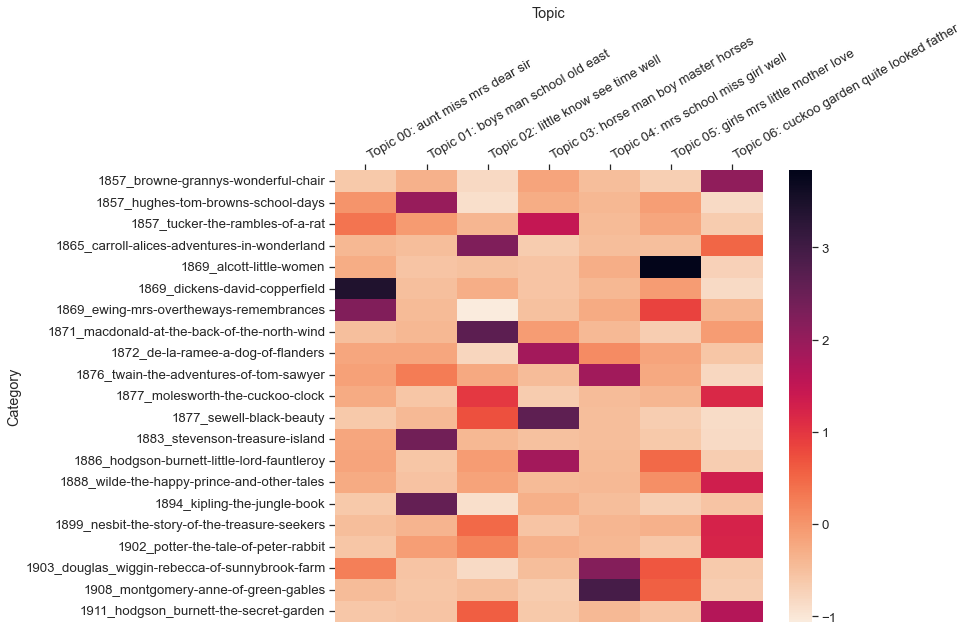

In [61]:
little_mallet_wrapper.plot_categories_by_topics_heatmap(book_titles,
                                      topic_distributions,
                                      topics, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )

The darker squares in this heatmap represent a high probability for the corresponding topic (compared to everyone else in the heatmap) and the lighter squares in the heatmap represent a low probability for the corresponding topic.

## Display Top Titles Per Topic

We can also display the books that have the highest probability for every topic with the `little_mallet_wrapper.get_top_docs()` function.

To display only the title of the book, we'll first need to make two dictionaries, which will allow us to find the corresponding book title and the original text from a given training document.

In [62]:
training_data_book_titles = dict(zip(training_data, book_titles))
training_data_original_text = dict(zip(training_data, original_texts))

Then we'll use the function `display_top_titles_per_topic()` that will display the top text titles for every topic. This function accepts a given `topic_number` as well as a desired `number_of_documents` to display.

In [66]:
def display_top_titles_per_topic(topic_number=0, number_of_documents=5):
    
    print(f"Topic {topic_number}\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        print(round(probability, 4), training_data_book_titles[document] + "\n")
    return

### Analysis of most relevant topics

After having analyzed the output topics, we try to identify those ones that seem to carry information that could potentially be associated to gender. 

In fact, amongst the extracted topics, there are some which appear to be more general, or at least bound more to the variety of the narrative genre than to the actual theme of the book (e.g. topic 2, containing words like 'little', 'know', 'see', 'time', 'well', 'long', 'day', 'away', etc.). But other topics, on the contrary, contain words that, besides being internally related, might be hypothetically associated to literature addressed to a specific gendered audience. If we assume that certain topics are traditionally destined to young male readers (e.g. adventure stories), while others to female readers (e.g. tales with a sentimental background or aimed at moral lessons), we can try and see if these expectations are confirmed by the results extracted from our corpus.  

From this standpoint, we identify the following topics as being the ones that carry potentially gender-related information:

**Male**:
  * *Topic 1* ['boys', 'man', 'school', 'old', 'east', 'doctor', 'men', 'captain', 'silver', 'half', 'last', 'back', 'big', 'side', 'round', 'island', 'ship', 'boy', 'first', 'sir']
  * *Topic 3* ['horse', 'man', 'boy', 'master', 'horses', 'lord', 'old', 'lady', 'little', 'men', 'fellow', 'quite', 'always', 'stable', 'cab', 'sir', 'heard', 'woman', 'hard', 'used'] 

**Female**:
  * *Topic 0* ['aunt', 'miss', 'mrs', 'dear', 'sir', 'old', 'returned', 'room', 'doctor', 'hand', 'life', 'house', 'looking', 'quite', 'love', 'head', 'face', 'manner', 'master', 'observed'] 
  * *Topic 5* ['girls', 'mrs', 'little', 'mother', 'love', 'home', 'dear', 'old', 'happy', 'lady', 'heart', 'new', 'away', 'life', 'read', 'help', 'isn', 'face', 'best', 'nice'] 

To display the top 3 book titles with the highest probability of containing the 4 chosen topics, we will run:

In [67]:
display_top_titles_per_topic(topic_number=1, number_of_documents=3)
display_top_titles_per_topic(topic_number=3, number_of_documents=3)
display_top_titles_per_topic(topic_number=0, number_of_documents=3)
display_top_titles_per_topic(topic_number=5, number_of_documents=3)

Topic 1

['boys', 'man', 'school', 'old', 'east', 'doctor', 'men', 'captain', 'silver', 'half', 'last', 'back', 'big', 'side', 'round', 'island', 'ship', 'boy', 'first', 'sir']

0.4656 1894_kipling-the-jungle-book

0.4412 1883_stevenson-treasure-island

0.3795 1857_hughes-tom-browns-school-days

Topic 3

['horse', 'man', 'boy', 'master', 'horses', 'lord', 'old', 'lady', 'little', 'men', 'fellow', 'quite', 'always', 'stable', 'cab', 'sir', 'heard', 'woman', 'hard', 'used']

0.3807 1877_sewell-black-beauty

0.2897 1886_hodgson-burnett-little-lord-fauntleroy

0.2896 1872_de-la-ramee-a-dog-of-flanders

Topic 0

['aunt', 'miss', 'mrs', 'dear', 'sir', 'old', 'returned', 'room', 'doctor', 'hand', 'life', 'house', 'looking', 'quite', 'love', 'head', 'face', 'manner', 'master', 'observed']

0.4071 1869_dickens-david-copperfield

0.2875 1869_ewing-mrs-overtheways-remembrances

0.0989 1857_tucker-the-rambles-of-a-rat

Topic 5

['girls', 'mrs', 'little', 'mother', 'love', 'home', 'dear', 'old', 'h

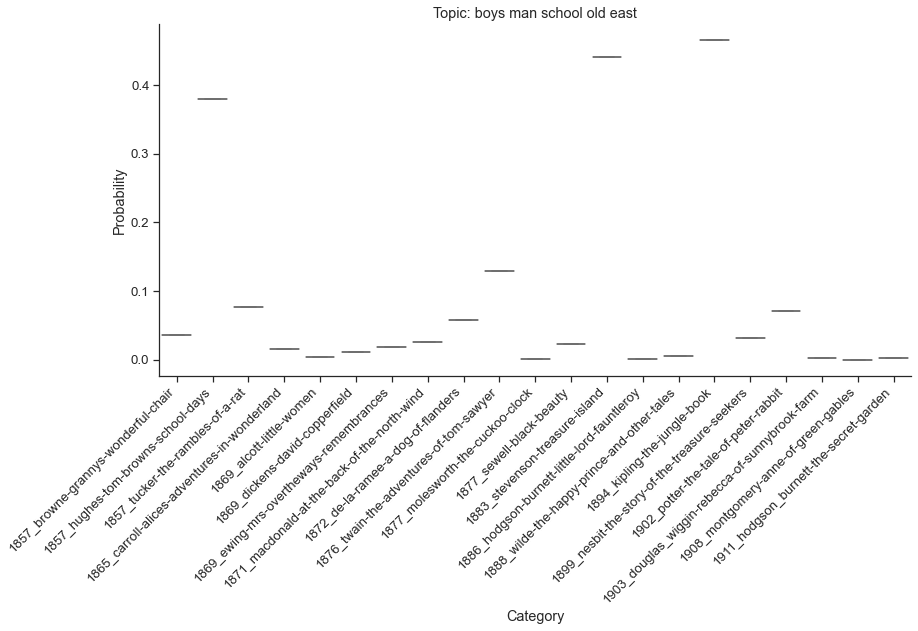

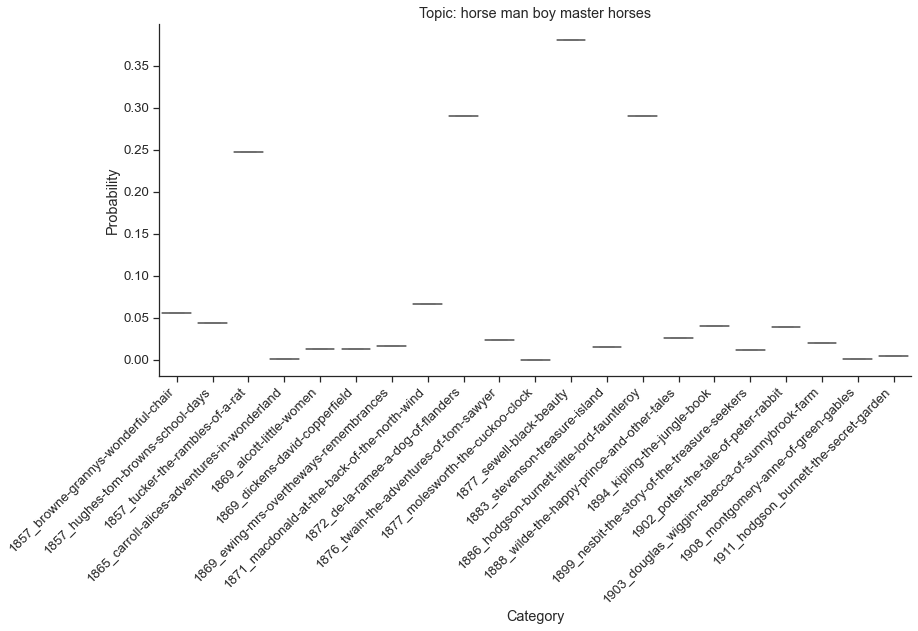

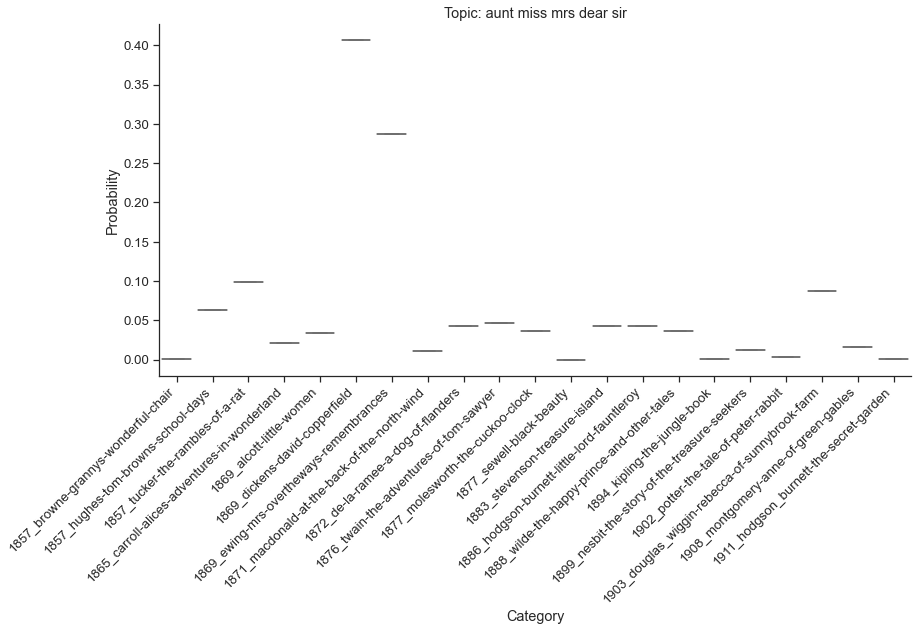

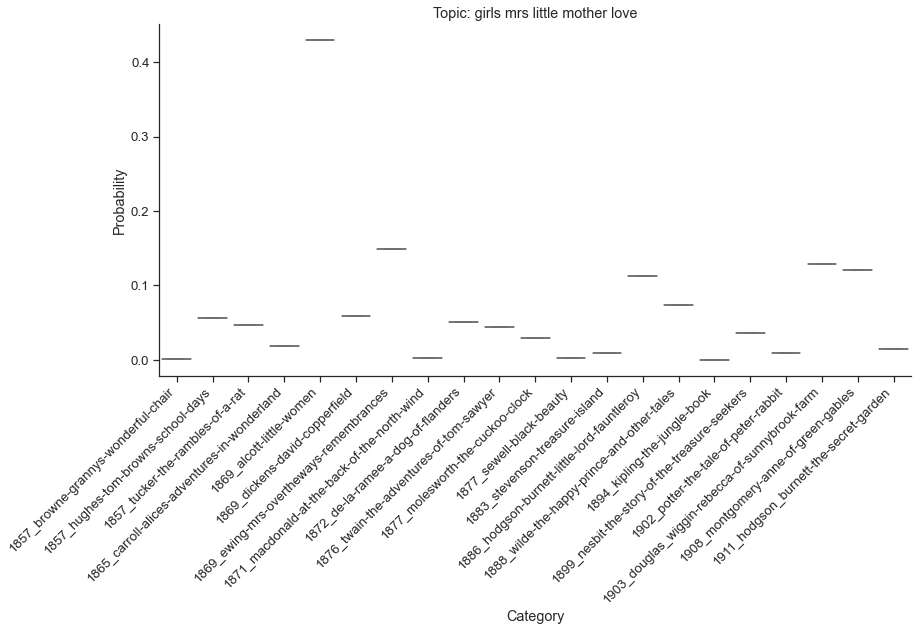

In [75]:
#MALE TOPICS: TOPIC 1
little_mallet_wrapper.plot_categories_by_topic_boxplots(book_titles,
                                      topic_distributions,
                                      topics, 
                                      target_topic_index=1,
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )
#MALE TOPICS: TOPIC 3
little_mallet_wrapper.plot_categories_by_topic_boxplots(book_titles,
                                      topic_distributions,
                                      topics, 
                                      target_topic_index=3,
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )
#FEMALE TOPICS: TOPIC 0
little_mallet_wrapper.plot_categories_by_topic_boxplots(book_titles,
                                      topic_distributions,
                                      topics, 
                                      target_topic_index=0,
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )
#FEMALE TOPICS: TOPIC 5
little_mallet_wrapper.plot_categories_by_topic_boxplots(book_titles,
                                      topic_distributions,
                                      topics, 
                                      target_topic_index=5,
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )
